



.
# PACKAGES AND LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from keras.models import Sequential,Model
from keras.layers import Input,Dense,GlobalAveragePooling2D, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback

from keras import models
from keras import layers
import tensorflow as tf
import os
import os.path
from pathlib import Path
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
from keras import regularizers
from tensorflow.keras.optimizers import RMSprop,Adam

from tensorflow.keras.applications.resnet50 import ResNet50



#### IGNORING WARNINGS


In [2]:
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

*italicized text*#### Data collection and Augmentation


In [3]:
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3039
Receiving objects: 100% (3039/3039), 79.25 MiB | 10.07 MiB/s, done.


In [4]:
import tensorflow as tf
import os
import os.path

from shutil import copyfile
from os import getcwd
from os import listdir
from pathlib import Path
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_data(file_dir, n_generated_samples, save_to_dir):
    #from keras.preprocessing.image import ImageDataGenerator
    #from os import listdir
    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        # load the image
        #print(file_dir + '/' + filename)
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break



data_path = '/content/Brain-Tumor-Classification-DataSet/Training/'
for folder in listdir(data_path):
  augment_data(file_dir=data_path+folder, n_generated_samples=1, save_to_dir=data_path+folder)

# PATH PROCESS

#### TRAIN

In [5]:
Train_Data_Path = Path("/content/Brain-Tumor-Classification-DataSet/Training")

In [6]:
Train_JPG_Path = list(Train_Data_Path.glob(r"*/*.jpg"))

In [7]:
print(Train_JPG_Path[0:10])

[PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/image(318).jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/aug_image(267)_0_4694.jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/aug_image(290)_0_9656.jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/aug_image (46)_0_8403.jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/aug_image (49)_0_9009.jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/image(32).jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/image(139).jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/aug_image (32)_0_9308.jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/aug_image(169)_0_5675.jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/aug_image(292)_0_5756.jpg')]


In [8]:
Train_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Train_JPG_Path))

In [9]:
print("NO: ",Train_JPG_Labels.count("no_tumor"))
print("Pituitary: ",Train_JPG_Labels.count("pituitary_tumor"))
print("Meningioma: ",Train_JPG_Labels.count("meningioma_tumor"))
print("Glioma: ",Train_JPG_Labels.count("glioma_tumor"))

NO:  1185
Pituitary:  2481
Meningioma:  2466
Glioma:  2478


In [10]:
Train_JPG_Path_Series = pd.Series(Train_JPG_Path,name="JPG").astype(str)
Train_JPG_Labels_Series = pd.Series(Train_JPG_Labels, name="TUMOR_CATEGORY")

In [11]:
print(Train_JPG_Path_Series.head())
print("-----"*20)
print(Train_JPG_Labels_Series.head())

0    /content/Brain-Tumor-Classification-DataSet/Tr...
1    /content/Brain-Tumor-Classification-DataSet/Tr...
2    /content/Brain-Tumor-Classification-DataSet/Tr...
3    /content/Brain-Tumor-Classification-DataSet/Tr...
4    /content/Brain-Tumor-Classification-DataSet/Tr...
Name: JPG, dtype: object
----------------------------------------------------------------------------------------------------
0    no_tumor
1    no_tumor
2    no_tumor
3    no_tumor
4    no_tumor
Name: TUMOR_CATEGORY, dtype: object


In [12]:
Main_Train_Data = pd.concat([Train_JPG_Path_Series,Train_JPG_Labels_Series],axis=1)

In [13]:
print(Main_Train_Data.head())

                                                 JPG TUMOR_CATEGORY
0  /content/Brain-Tumor-Classification-DataSet/Tr...       no_tumor
1  /content/Brain-Tumor-Classification-DataSet/Tr...       no_tumor
2  /content/Brain-Tumor-Classification-DataSet/Tr...       no_tumor
3  /content/Brain-Tumor-Classification-DataSet/Tr...       no_tumor
4  /content/Brain-Tumor-Classification-DataSet/Tr...       no_tumor


#### TEST

In [14]:
Test_Data_Path = Path("/content/Brain-Tumor-Classification-DataSet/Testing")

In [15]:
Test_JPG_Path = list(Test_Data_Path.glob(r"*/*.jpg"))

In [16]:
print(Test_JPG_Path[0:5])

[PosixPath('/content/Brain-Tumor-Classification-DataSet/Testing/no_tumor/image(32).jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Testing/no_tumor/image(22).jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Testing/no_tumor/image(78).jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Testing/no_tumor/image(86).jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Testing/no_tumor/image(82).jpg')]


In [17]:
Test_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Test_JPG_Path))

In [18]:
print("NO: ",Test_JPG_Labels.count("no_tumor"))
print("Pituitary: ",Test_JPG_Labels.count("pituitary_tumor"))
print("Meningioma: ",Test_JPG_Labels.count("meningioma_tumor"))
print("Glioma: ",Test_JPG_Labels.count("glioma_tumor"))

NO:  105
Pituitary:  74
Meningioma:  115
Glioma:  100


In [19]:
Test_JPG_Path_Series = pd.Series(Test_JPG_Path,name="JPG").astype(str)
Test_JPG_Labels_Labels = pd.Series(Test_JPG_Labels,name="TUMOR_CATEGORY")

In [20]:
print(Test_JPG_Path_Series.head())
print("-----"*20)
print(Test_JPG_Labels_Labels.head())

0    /content/Brain-Tumor-Classification-DataSet/Te...
1    /content/Brain-Tumor-Classification-DataSet/Te...
2    /content/Brain-Tumor-Classification-DataSet/Te...
3    /content/Brain-Tumor-Classification-DataSet/Te...
4    /content/Brain-Tumor-Classification-DataSet/Te...
Name: JPG, dtype: object
----------------------------------------------------------------------------------------------------
0    no_tumor
1    no_tumor
2    no_tumor
3    no_tumor
4    no_tumor
Name: TUMOR_CATEGORY, dtype: object


In [21]:
Main_Test_Data = pd.concat([Test_JPG_Path_Series,Test_JPG_Labels_Labels],axis=1)

In [22]:
print(Main_Test_Data.head())

                                                 JPG TUMOR_CATEGORY
0  /content/Brain-Tumor-Classification-DataSet/Te...       no_tumor
1  /content/Brain-Tumor-Classification-DataSet/Te...       no_tumor
2  /content/Brain-Tumor-Classification-DataSet/Te...       no_tumor
3  /content/Brain-Tumor-Classification-DataSet/Te...       no_tumor
4  /content/Brain-Tumor-Classification-DataSet/Te...       no_tumor


# SHUFFLING

In [23]:
Main_Train_Data = Main_Train_Data.sample(frac=1).reset_index(drop=True)
Main_Test_Data = Main_Test_Data.sample(frac=1).reset_index(drop=True)

In [24]:
print(Main_Train_Data.head(10))
print("----"*20)
print(Main_Test_Data.head(10))

                                                 JPG    TUMOR_CATEGORY
0  /content/Brain-Tumor-Classification-DataSet/Tr...   pituitary_tumor
1  /content/Brain-Tumor-Classification-DataSet/Tr...  meningioma_tumor
2  /content/Brain-Tumor-Classification-DataSet/Tr...          no_tumor
3  /content/Brain-Tumor-Classification-DataSet/Tr...      glioma_tumor
4  /content/Brain-Tumor-Classification-DataSet/Tr...          no_tumor
5  /content/Brain-Tumor-Classification-DataSet/Tr...  meningioma_tumor
6  /content/Brain-Tumor-Classification-DataSet/Tr...      glioma_tumor
7  /content/Brain-Tumor-Classification-DataSet/Tr...   pituitary_tumor
8  /content/Brain-Tumor-Classification-DataSet/Tr...   pituitary_tumor
9  /content/Brain-Tumor-Classification-DataSet/Tr...   pituitary_tumor
--------------------------------------------------------------------------------
                                                 JPG    TUMOR_CATEGORY
0  /content/Brain-Tumor-Classification-DataSet/Te...      glioma_tu

# REPLACE NAME

In [25]:
Main_Train_Data["TUMOR_CATEGORY"].replace({"glioma_tumor":"Glioma",
                                         "meningioma_tumor":"Meningioma",
                                         "no_tumor":"No",
                                         "pituitary_tumor":"Pituitary"},inplace=True)

In [26]:
print(Main_Train_Data.head())

                                                 JPG TUMOR_CATEGORY
0  /content/Brain-Tumor-Classification-DataSet/Tr...      Pituitary
1  /content/Brain-Tumor-Classification-DataSet/Tr...     Meningioma
2  /content/Brain-Tumor-Classification-DataSet/Tr...             No
3  /content/Brain-Tumor-Classification-DataSet/Tr...         Glioma
4  /content/Brain-Tumor-Classification-DataSet/Tr...             No


In [27]:
Main_Test_Data["TUMOR_CATEGORY"].replace({"glioma_tumor":"Glioma",
                                         "meningioma_tumor":"Meningioma",
                                         "no_tumor":"No",
                                         "pituitary_tumor":"Pituitary"},inplace=True)

In [28]:
print(Main_Test_Data.head())

                                                 JPG TUMOR_CATEGORY
0  /content/Brain-Tumor-Classification-DataSet/Te...         Glioma
1  /content/Brain-Tumor-Classification-DataSet/Te...             No
2  /content/Brain-Tumor-Classification-DataSet/Te...             No
3  /content/Brain-Tumor-Classification-DataSet/Te...         Glioma
4  /content/Brain-Tumor-Classification-DataSet/Te...         Glioma


# VISUALIZATION

#### TRAIN

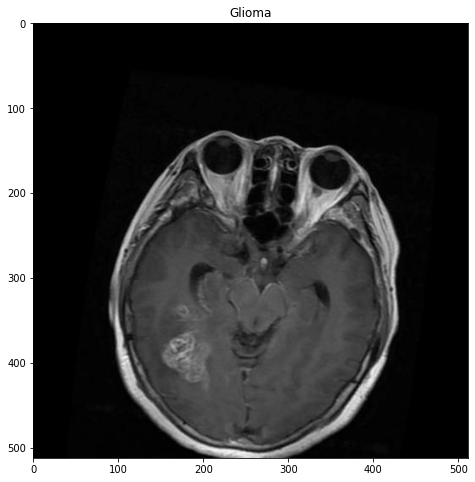

In [29]:
figure = plt.figure(figsize=(8,8))
plt.imshow(plt.imread(Main_Train_Data["JPG"][10],0))
plt.title(Main_Train_Data["TUMOR_CATEGORY"][10])
plt.show()

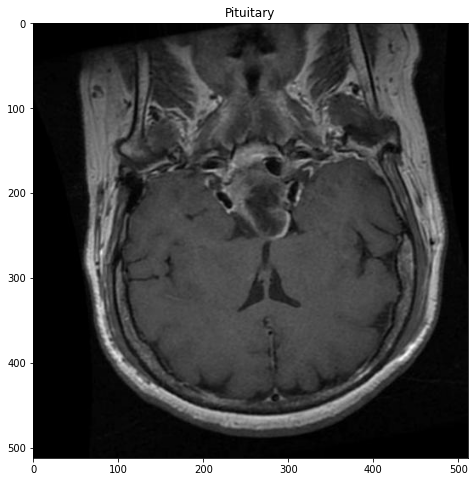

In [30]:
figure = plt.figure(figsize=(8,8))
plt.imshow(plt.imread(Main_Train_Data["JPG"][7],0))
plt.title(Main_Train_Data["TUMOR_CATEGORY"][7])
plt.show()

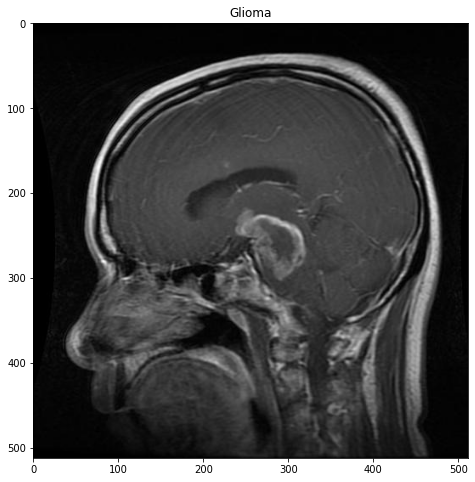

In [31]:
figure = plt.figure(figsize=(8,8))
plt.imshow(plt.imread(Main_Train_Data["JPG"][200],0))
plt.title(Main_Train_Data["TUMOR_CATEGORY"][200])
plt.show()

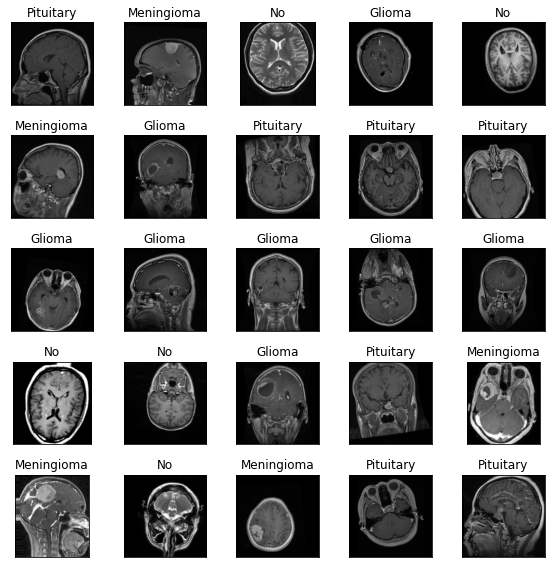

In [32]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Train_Data["JPG"][i]))
    ax.set_title(Main_Train_Data["TUMOR_CATEGORY"][i])
plt.tight_layout()
plt.show()

#### TEST

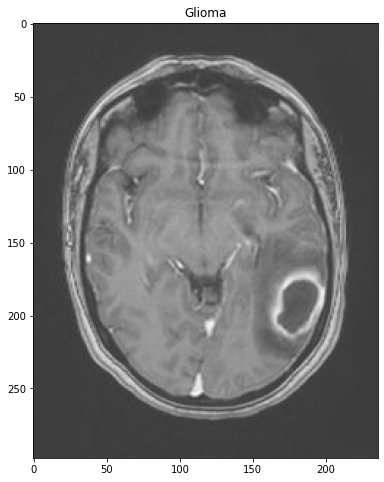

In [33]:
figure = plt.figure(figsize=(8,8))
plt.imshow(plt.imread(Main_Test_Data["JPG"][200],0))
plt.title(Main_Test_Data["TUMOR_CATEGORY"][200])
plt.show()

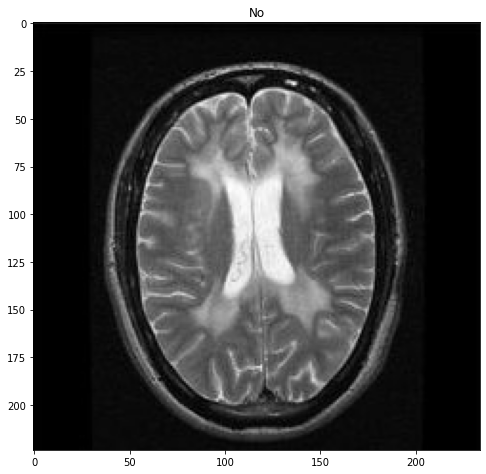

In [34]:
figure = plt.figure(figsize=(8,8))
plt.imshow(plt.imread(Main_Test_Data["JPG"][2],0))
plt.title(Main_Test_Data["TUMOR_CATEGORY"][2])
plt.show()

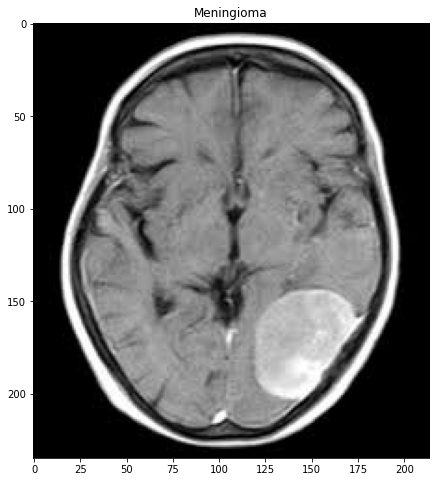

In [35]:
figure = plt.figure(figsize=(8,8))
plt.imshow(plt.imread(Main_Test_Data["JPG"][12],0))
plt.title(Main_Test_Data["TUMOR_CATEGORY"][12])
plt.show()

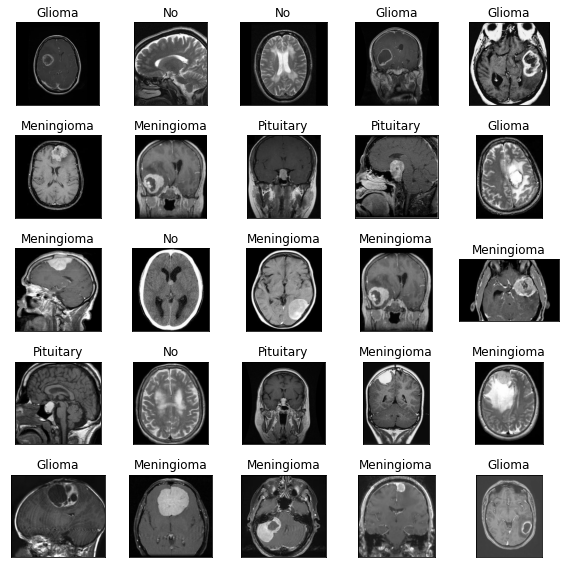

In [36]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Test_Data["JPG"][i]))
    ax.set_title(Main_Test_Data["TUMOR_CATEGORY"][i])
plt.tight_layout()
plt.show()

# MODEL TRAINING DATA

In [37]:
train_data,test_data = train_test_split(Main_Train_Data,train_size=0.9,random_state=42)

In [38]:
print(train_data.shape)

(7749, 2)


In [39]:
print(test_data.shape)

(861, 2)


# IMAGE GENERATOR

In [40]:
Generator = ImageDataGenerator(rescale=1./255,
                               brightness_range=[0.2,0.9],
                               featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0, validation_split=0.1)

In [41]:
Train_Set = Generator.flow_from_dataframe(dataframe=train_data,
                                         x_col="JPG",
                                         y_col="TUMOR_CATEGORY",
                                         seed=42,
                                          color_mode="rgb",
                                         class_mode="categorical",
                                          batch_size=10,
                                         subset="training"
                                         )

Found 6975 validated image filenames belonging to 4 classes.


In [42]:
print(Train_Set.class_indices)
print(Train_Set.classes[0:5])
print(Train_Set.image_shape)

{'Glioma': 0, 'Meningioma': 1, 'No': 2, 'Pituitary': 3}
[1, 3, 2, 0, 1]
(256, 256, 3)


In [43]:
Validation_Set = Generator.flow_from_dataframe(dataframe=train_data,
                                              x_col="JPG",
                                              y_col="TUMOR_CATEGORY",
                                              seed=42,
                                               color_mode="rgb",
                                              class_mode="categorical",
                                              batch_size=10,
                                               subset="validation"
                                              )

Found 774 validated image filenames belonging to 4 classes.


In [44]:
print(Validation_Set.class_indices)
print(Validation_Set.classes[0:5])
print(Validation_Set.image_shape)

{'Glioma': 0, 'Meningioma': 1, 'No': 2, 'Pituitary': 3}
[3, 3, 0, 2, 0]
(256, 256, 3)


In [45]:
Test_Set = Generator.flow_from_dataframe(dataframe=test_data,
                                              x_col="JPG",
                                              y_col="TUMOR_CATEGORY",
                                              seed=42,
                                               color_mode="rgb",
                                              class_mode="categorical",
                                              batch_size=10
                                              )

Found 861 validated image filenames belonging to 4 classes.


In [46]:
print(Test_Set.class_indices)
print(Test_Set.classes[0:5])
print(Test_Set.image_shape)

{'Glioma': 0, 'Meningioma': 1, 'No': 2, 'Pituitary': 3}
[2, 1, 3, 3, 3]
(256, 256, 3)


In [47]:
Model = Sequential()
#
Model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 activation ='relu', input_shape = (256,256,3)))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))

#
Model.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 activation ='relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))

#
Model.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 activation ='relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))

#
Model.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 activation ='relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))

# 
Model.add(Flatten())
Model.add(Dense(256, activation = "relu"))
Model.add(Dropout(0.25))
Model.add(Dense(4, activation = "softmax"))

In [48]:
Model.compile(optimizer=RMSprop(lr=0.001),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [49]:
Call_Back = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=2,mode="min")

In [50]:
ANN_Model = Model.fit(Train_Set,
                      validation_data=Validation_Set,
                     epochs=20,
                      batch_size=20,
                     callbacks=Call_Back)

Epoch 1/20
698/698 [==============================] - 57s 68ms/step - loss: 1.2184 - accuracy: 0.4705 - val_loss: 0.9970 - val_accuracy: 0.5556
Epoch 2/20
698/698 [==============================] - 46s 66ms/step - loss: 0.9262 - accuracy: 0.6044 - val_loss: 0.9290 - val_accuracy: 0.6525
Epoch 3/20
698/698 [==============================] - 46s 66ms/step - loss: 0.8009 - accuracy: 0.6664 - val_loss: 0.8011 - val_accuracy: 0.6550
Epoch 4/20
698/698 [==============================] - 46s 66ms/step - loss: 0.7225 - accuracy: 0.7147 - val_loss: 0.7482 - val_accuracy: 0.6938
Epoch 5/20
698/698 [==============================] - 46s 66ms/step - loss: 0.6682 - accuracy: 0.7385 - val_loss: 0.7340 - val_accuracy: 0.7041
Epoch 6/20
698/698 [==============================] - 46s 66ms/step - loss: 0.6300 - accuracy: 0.7511 - val_loss: 0.7384 - val_accuracy: 0.7248
Epoch 7/20
698/698 [==============================] - 46s 66ms/step - loss: 0.6141 - accuracy: 0.7710 - val_loss: 0.6547 - val_accuracy:

In [51]:
Model_Results = Model.evaluate(Test_Set,verbose=True)
print("Keras evaluation lOSS:  " + "%.4f" % Model_Results[0])
print("Keras evaluation ACCURACY:  " + "%.2f" % Model_Results[1])

87/87 [==============================] - 5s 60ms/step - loss: 0.6425 - accuracy: 0.7909
Keras evaluation lOSS:  0.6425
Keras evaluation ACCURACY:  0.79


In [52]:
print(Model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 128)       0

No handles with labels found to put in legend.


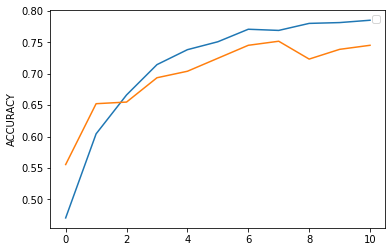

In [53]:
plt.plot(ANN_Model.history["accuracy"])
plt.plot(ANN_Model.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

## ANN Model 2 with 2 Layers more

In [54]:
Model2 = Sequential()
#
Model2.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 activation ='relu', input_shape = (256,256,3)))
Model2.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))

#
Model2.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 activation ='relu'))
Model2.add(MaxPool2D(pool_size=(2,2)))
Model2.add(Dropout(0.2))


Model2.add(Flatten())
Model2.add(Dense(256, activation = "relu"))
Model2.add(Dropout(0.25))
Model2.add(Dense(4, activation = "softmax"))

In [55]:
Model2.compile(optimizer=RMSprop(lr=0.001),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [56]:
Call_Back = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=2,mode="min")

In [57]:
ANN_Model2 = Model2.fit(Train_Set,
                      validation_data=Validation_Set,
                     epochs=20,
                      batch_size=20,
                     callbacks=Call_Back)

Epoch 1/20
698/698 [==============================] - 47s 66ms/step - loss: 1.2660 - accuracy: 0.4925 - val_loss: 1.6959 - val_accuracy: 0.4444
Epoch 2/20
698/698 [==============================] - 46s 66ms/step - loss: 0.8478 - accuracy: 0.6500 - val_loss: 0.7997 - val_accuracy: 0.6770
Epoch 3/20
698/698 [==============================] - 46s 66ms/step - loss: 0.6801 - accuracy: 0.7254 - val_loss: 0.9606 - val_accuracy: 0.6680
Epoch 4/20
698/698 [==============================] - 46s 66ms/step - loss: 0.5648 - accuracy: 0.7891 - val_loss: 1.1078 - val_accuracy: 0.6667
Epoch 5/20
698/698 [==============================] - 46s 66ms/step - loss: 0.4310 - accuracy: 0.8434 - val_loss: 0.8712 - val_accuracy: 0.6912
Epoch 6/20
698/698 [==============================] - 46s 66ms/step - loss: 0.3632 - accuracy: 0.8809 - val_loss: 1.2184 - val_accuracy: 0.6822
Epoch 7/20
698/698 [==============================] - 46s 66ms/step - loss: 0.3019 - accuracy: 0.9031 - val_loss: 1.3772 - val_accuracy:

In [58]:
HistoryDict = ANN_Model.history

val_losses = HistoryDict["val_loss"]
val_acc = HistoryDict["val_accuracy"]
acc = HistoryDict["accuracy"]
losses = HistoryDict["loss"]
epochs = range(1,len(val_losses)+1)

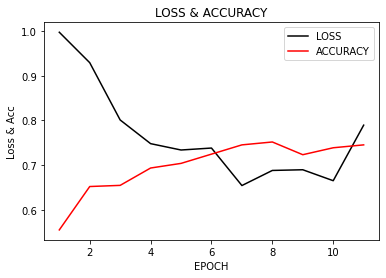

In [59]:
plt.plot(epochs,val_losses,"k-",label="LOSS")
plt.plot(epochs,val_acc,"r",label="ACCURACY")
plt.title("LOSS & ACCURACY")
plt.xlabel("EPOCH")
plt.ylabel("Loss & Acc")
plt.legend()
plt.show()

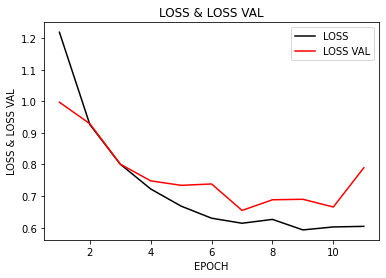

In [60]:
plt.plot(epochs,losses,"k-",label="LOSS")
plt.plot(epochs,val_losses,"r",label="LOSS VAL")
plt.title("LOSS & LOSS VAL")
plt.xlabel("EPOCH")
plt.ylabel("LOSS & LOSS VAL")
plt.legend()
plt.show()

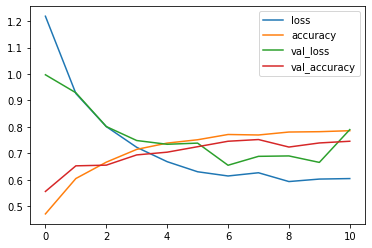

In [61]:
Dict_Summary = pd.DataFrame(ANN_Model.history)
Dict_Summary.plot()

# PREDICTION PROCESS

In [62]:
Main_Test_Set = Generator.flow_from_dataframe(dataframe=Main_Test_Data,
                                              x_col="JPG",
                                              y_col="TUMOR_CATEGORY",
                                              seed=42,
                                               color_mode="rgb",
                                              class_mode="categorical",
                                              batch_size=20
                                              )

Found 394 validated image filenames belonging to 4 classes.


In [63]:
Model_Predict = Model.predict(Main_Test_Set)
Model_Predict2=Model2.predict(Main_Test_Set)

In [64]:
Model_Predict = np.argmax(Model_Predict,axis=1)
Model_Predict2 = np.argmax(Model_Predict2,axis=1)

In [65]:
Predict_Label = (Main_Test_Set.class_indices)
Predict_Label = dict((v,k) for k,v in Predict_Label.items())


In [66]:
Model_Predict = [Predict_Label[k] for k in Model_Predict]
Model_Predict2 = [Predict_Label[k] for k in Model_Predict2]

In [67]:
print(Model_Predict[:50])

['No', 'Meningioma', 'Pituitary', 'No', 'Meningioma', 'Meningioma', 'No', 'Meningioma', 'Meningioma', 'Pituitary', 'No', 'Glioma', 'Pituitary', 'No', 'Meningioma', 'Meningioma', 'Pituitary', 'Pituitary', 'Pituitary', 'Glioma', 'No', 'No', 'No', 'Glioma', 'Pituitary', 'Meningioma', 'Glioma', 'No', 'No', 'No', 'No', 'No', 'Pituitary', 'Meningioma', 'Pituitary', 'Meningioma', 'Meningioma', 'Meningioma', 'Glioma', 'Pituitary', 'No', 'Meningioma', 'Meningioma', 'No', 'Glioma', 'Meningioma', 'Meningioma', 'Glioma', 'Meningioma', 'Pituitary']


In [68]:
Test_Results = list(Main_Test_Data["TUMOR_CATEGORY"])

In [69]:
print(Test_Results[:50])

['Glioma', 'No', 'No', 'Glioma', 'Glioma', 'Meningioma', 'Meningioma', 'Pituitary', 'Pituitary', 'Glioma', 'Meningioma', 'No', 'Meningioma', 'Meningioma', 'Meningioma', 'Pituitary', 'No', 'Pituitary', 'Meningioma', 'Meningioma', 'Glioma', 'Meningioma', 'Meningioma', 'Meningioma', 'Glioma', 'Glioma', 'Pituitary', 'Pituitary', 'Glioma', 'Meningioma', 'No', 'Meningioma', 'Glioma', 'No', 'Pituitary', 'Glioma', 'No', 'No', 'Pituitary', 'Glioma', 'Meningioma', 'Meningioma', 'No', 'Pituitary', 'Glioma', 'Glioma', 'Meningioma', 'Meningioma', 'Pituitary', 'Pituitary']


In [70]:
print("Compartison")
print("Class_Report")
Class_Report = classification_report(Test_Results,Model_Predict)
print(Class_Report)
#2
Class_Report2 = classification_report(Test_Results,Model_Predict2)
print("Class_Report2")
print(Class_Report2)

Compartison
Class_Report
              precision    recall  f1-score   support

      Glioma       0.30      0.12      0.17       100
  Meningioma       0.27      0.34      0.30       115
          No       0.25      0.30      0.27       105
   Pituitary       0.18      0.20      0.19        74

    accuracy                           0.25       394
   macro avg       0.25      0.24      0.23       394
weighted avg       0.25      0.25      0.24       394

Class_Report2
              precision    recall  f1-score   support

      Glioma       0.23      0.05      0.08       100
  Meningioma       0.32      0.35      0.33       115
          No       0.23      0.41      0.29       105
   Pituitary       0.18      0.15      0.16        74

    accuracy                           0.25       394
   macro avg       0.24      0.24      0.22       394
weighted avg       0.25      0.25      0.23       394



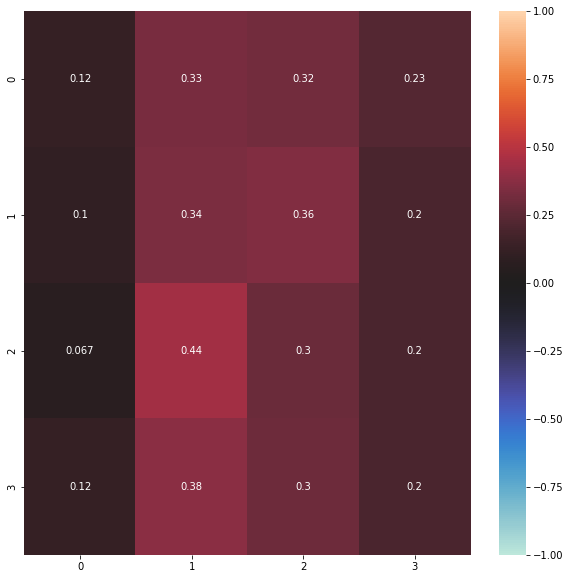

In [71]:
Conf_Report = confusion_matrix(Test_Results,Model_Predict, normalize="true")
figure = plt.figure(figsize=(10,10))
sns.heatmap(Conf_Report,vmax=1,center=0,vmin=-1,annot=True)
plt.show()

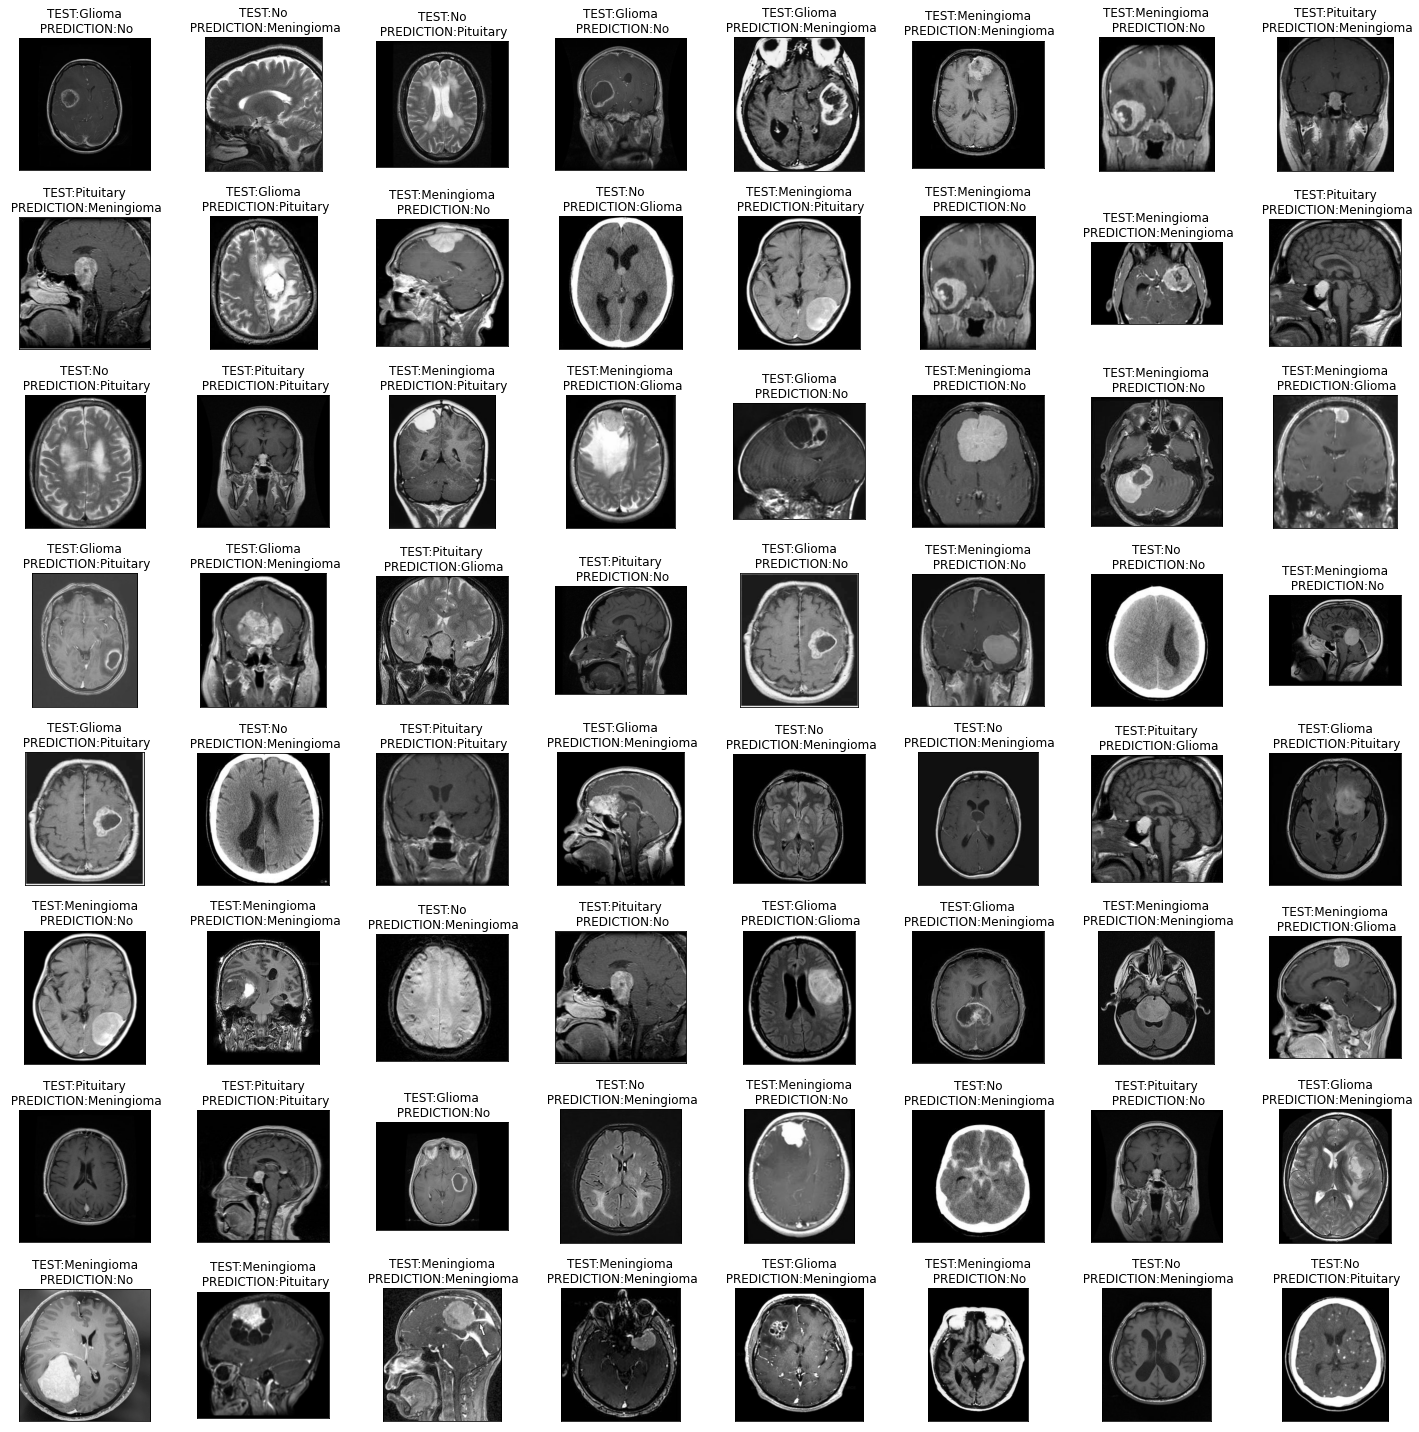

In [72]:
fig, axes = plt.subplots(nrows=8,
                         ncols=8,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Test_Data["JPG"].iloc[i]))
    ax.set_title(f"TEST:{Main_Test_Data.TUMOR_CATEGORY.iloc[i]}\n PREDICTION:{Model_Predict[i]}")
plt.tight_layout()
plt.show()

# CNN MODEL 

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
from tensorflow import keras
import operator

In [74]:
image_size=256

In [75]:
S_CNN_model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
S_CNN_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
S_CNN_model.add(tf.keras.layers.Dropout(0.45))

S_CNN_model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9,padding='same', activation='relu'))
S_CNN_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
S_CNN_model.add(tf.keras.layers.Dropout(0.25))

S_CNN_model.add(tf.keras.layers.Conv2D(filters=36, kernel_size=9, padding='same', activation='relu'))
S_CNN_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
S_CNN_model.add(tf.keras.layers.Dropout(0.25))

S_CNN_model.add(tf.keras.layers.Flatten())

S_CNN_model.add(tf.keras.layers.Dense(512, activation='relu'))
S_CNN_model.add(tf.keras.layers.Dropout(0.15))


S_CNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [76]:
S_CNN_model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc'])

S_CNN_model.fit(Train_Set,epochs =20,validation_data=Validation_Set, verbose=1, batch_size=32,
                   )


Epoch 1/20
698/698 [==============================] - 47s 66ms/step - loss: 0.5768 - acc: 0.7473 - val_loss: 0.5630 - val_acc: 0.7500
Epoch 2/20
698/698 [==============================] - 45s 65ms/step - loss: 0.5627 - acc: 0.7500 - val_loss: 0.5624 - val_acc: 0.7500
Epoch 3/20
698/698 [==============================] - 45s 65ms/step - loss: 0.5626 - acc: 0.7500 - val_loss: 0.5627 - val_acc: 0.7500
Epoch 4/20
698/698 [==============================] - 45s 65ms/step - loss: 0.5626 - acc: 0.7500 - val_loss: 0.5625 - val_acc: 0.7500
Epoch 5/20
698/698 [==============================] - 46s 65ms/step - loss: 0.5625 - acc: 0.7500 - val_loss: 0.5625 - val_acc: 0.7500
Epoch 6/20
698/698 [==============================] - 45s 65ms/step - loss: 0.5625 - acc: 0.7500 - val_loss: 0.5625 - val_acc: 0.7500
Epoch 7/20
698/698 [==============================] - 46s 65ms/step - loss: 0.5625 - acc: 0.7500 - val_loss: 0.5623 - val_acc: 0.7500
Epoch 8/20
698/698 [==============================] - 45s 65ms

In [77]:

# Take a look at the model summary
S_CNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_6 (MaxPooling  (None, None, None, None)  0        
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, None, None, None)  0         
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 16)    3904      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, None, None, 16)   0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, None, None, 16)    0         
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 36)   

In [78]:
logdir = 'logs'
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)
checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{acc:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')


history = S_CNN_model.fit(Train_Set,epochs =2,validation_data=Validation_Set, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint])

Epoch 1/2
698/698 [==============================] - ETA: 0s - loss: 0.5623 - acc: 0.7500
Epoch 00001: val_loss improved from inf to 0.56234, saving model to model-01-0.75-0.56.h5
698/698 [==============================] - 47s 68ms/step - loss: 0.5623 - acc: 0.7500 - val_loss: 0.5623 - val_acc: 0.7500
Epoch 2/2
698/698 [==============================] - ETA: 0s - loss: 0.5623 - acc: 0.7500
Epoch 00002: val_loss did not improve from 0.56234
698/698 [==============================] - 46s 66ms/step - loss: 0.5623 - acc: 0.7500 - val_loss: 0.5623 - val_acc: 0.7500


In [79]:
S_CNN_model_Results = S_CNN_model.evaluate(Test_Set,verbose=False)
print("LOSS:  " + "%.4f" % S_CNN_model_Results[0])
print("ACCURACY:  " + "%.2f" % S_CNN_model_Results[1])

LOSS:  0.5623
ACCURACY:  0.75


In [80]:
print(S_CNN_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_6 (MaxPooling  (None, None, None, None)  0        
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, None, None, None)  0         
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 16)    3904      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, None, None, 16)   0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, None, None, 16)    0         
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 36)   

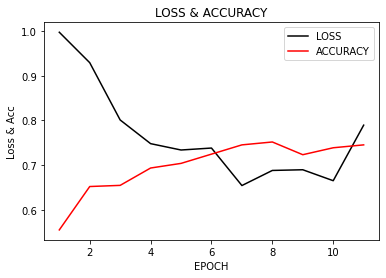

In [81]:
plt.plot(epochs,val_losses,"k-",label="LOSS")
plt.plot(epochs,val_acc,"r",label="ACCURACY")
plt.title("LOSS & ACCURACY")
plt.xlabel("EPOCH")
plt.ylabel("Loss & Acc")
plt.legend()
plt.show()

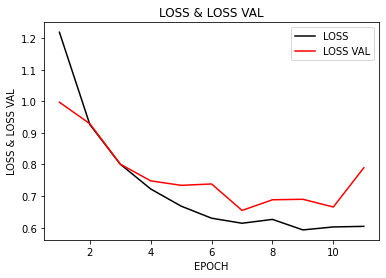

In [82]:
plt.plot(epochs,losses,"k-",label="LOSS")
plt.plot(epochs,val_losses,"r",label="LOSS VAL")
plt.title("LOSS & LOSS VAL")
plt.xlabel("EPOCH")
plt.ylabel("LOSS & LOSS VAL")
plt.legend()
plt.show()

In [83]:
S_CNN_Model_Predict = S_CNN_model.predict(Main_Test_Set)


In [84]:
S_CNN_Model_Predict = np.argmax(S_CNN_Model_Predict,axis=1)


In [85]:
Predict_Label = (Main_Test_Set.class_indices)
Predict_Label = dict((v,k) for k,v in Predict_Label.items())


In [86]:
S_CNN_Model_Predict = [Predict_Label[k] for k in S_CNN_Model_Predict]


In [87]:
print(S_CNN_Model_Predict[:50])

['Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma']


In [88]:
Test_Results = list(Main_Test_Data["TUMOR_CATEGORY"])

In [89]:
print(Test_Results[:50])

['Glioma', 'No', 'No', 'Glioma', 'Glioma', 'Meningioma', 'Meningioma', 'Pituitary', 'Pituitary', 'Glioma', 'Meningioma', 'No', 'Meningioma', 'Meningioma', 'Meningioma', 'Pituitary', 'No', 'Pituitary', 'Meningioma', 'Meningioma', 'Glioma', 'Meningioma', 'Meningioma', 'Meningioma', 'Glioma', 'Glioma', 'Pituitary', 'Pituitary', 'Glioma', 'Meningioma', 'No', 'Meningioma', 'Glioma', 'No', 'Pituitary', 'Glioma', 'No', 'No', 'Pituitary', 'Glioma', 'Meningioma', 'Meningioma', 'No', 'Pituitary', 'Glioma', 'Glioma', 'Meningioma', 'Meningioma', 'Pituitary', 'Pituitary']


In [90]:

print("S_CNN_Model_Predict Class_Report")
Class_Report = classification_report(Test_Results,S_CNN_Model_Predict)
print(Class_Report)


S_CNN_Model_Predict Class_Report
              precision    recall  f1-score   support

      Glioma       0.25      1.00      0.40       100
  Meningioma       0.00      0.00      0.00       115
          No       0.00      0.00      0.00       105
   Pituitary       0.00      0.00      0.00        74

    accuracy                           0.25       394
   macro avg       0.06      0.25      0.10       394
weighted avg       0.06      0.25      0.10       394



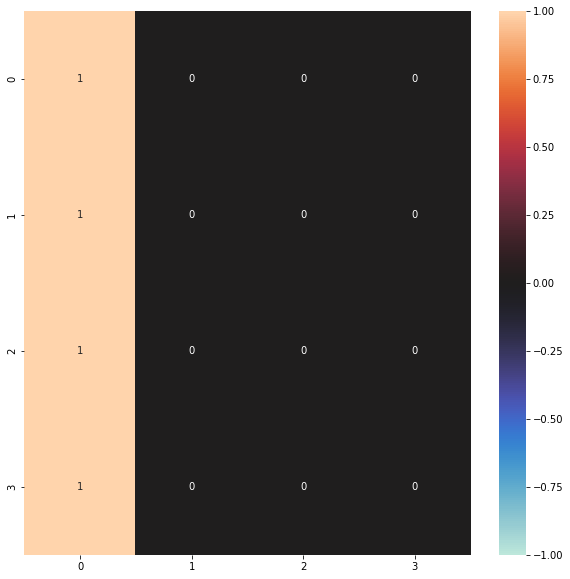

In [91]:
Conf_Report = confusion_matrix(Test_Results,S_CNN_Model_Predict, normalize="true")
figure = plt.figure(figsize=(10,10))
sns.heatmap(Conf_Report,vmax=1,center=0,vmin=-1,annot=True)
plt.show()

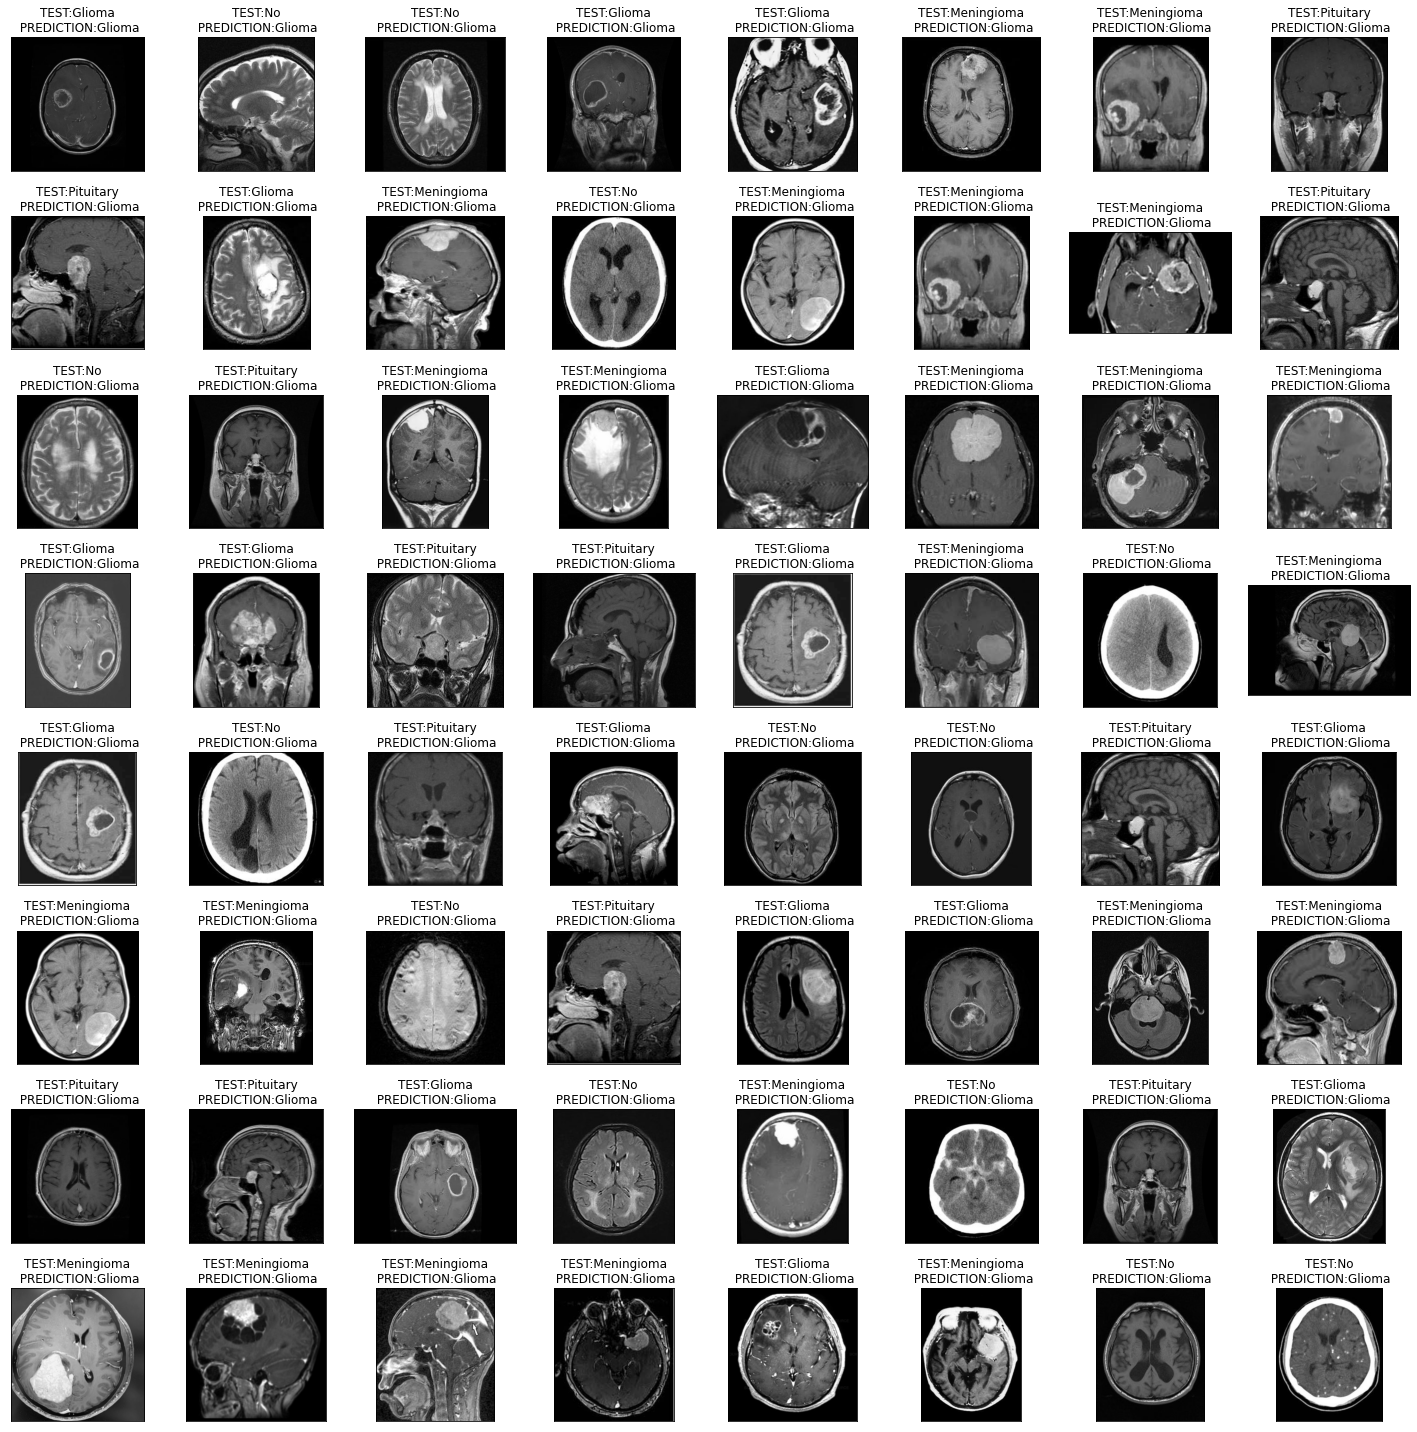

In [92]:
fig, axes = plt.subplots(nrows=8,
                         ncols=8,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Test_Data["JPG"].iloc[i]))
    ax.set_title(f"TEST:{Main_Test_Data.TUMOR_CATEGORY.iloc[i]}\n PREDICTION:{S_CNN_Model_Predict[i]}")
plt.tight_layout()
plt.show()

In [93]:
#%tensorboard --logdir logs


UsageError: Line magic function `%tensorboard` not found.


# Combination of ALL models 

In [94]:
Models=[Model,Model2,S_CNN_model]

def Model_Predict(Models,X):
  Predictions=[]
  for i in range(len(Models)):
    Model_Predict = Models[i].predict(X)
    Model_Predict = np.argmax(Model_Predict,axis=1)
    
    Predict_Label = (X.class_indices)
    Predict_Label = dict((v,k) for k,v in Predict_Label.items())
    
    Model_Predict = [Predict_Label[k] for k in Model_Predict]
    
    Predictions+=[Model_Predict]
  Predictions=np.array(Predictions)
  Predictions=Predictions.transpose()
  Final_Prediction=[]
  for i in range(len(Predictions)):
    unique, counts = np.unique(Predictions[i], return_counts=True)
    max_key = max(dict(zip(unique, counts)).items(), key=operator.itemgetter(1))[0]
    Final_Prediction+=[max_key]
  return Final_Prediction

In [95]:

Combinaison_models = Model_Predict(Models,Main_Test_Set)

In [96]:
print("Combinaison_models Class_Report")
Class_Report = classification_report(Test_Results,Combinaison_models)
print(Class_Report)

Combinaison_models Class_Report
              precision    recall  f1-score   support

      Glioma       0.27      0.75      0.39       100
  Meningioma       0.33      0.11      0.17       115
          No       0.28      0.17      0.21       105
   Pituitary       0.00      0.00      0.00        74

    accuracy                           0.27       394
   macro avg       0.22      0.26      0.19       394
weighted avg       0.24      0.27      0.21       394



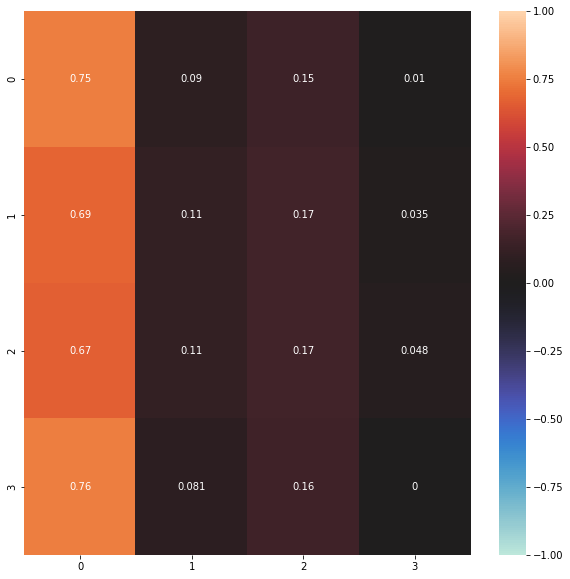

In [97]:
Conf_Report = confusion_matrix(Test_Results,Combinaison_models, normalize="true")
figure = plt.figure(figsize=(10,10))
sns.heatmap(Conf_Report,vmax=1,center=0,vmin=-1,annot=True)
plt.show()

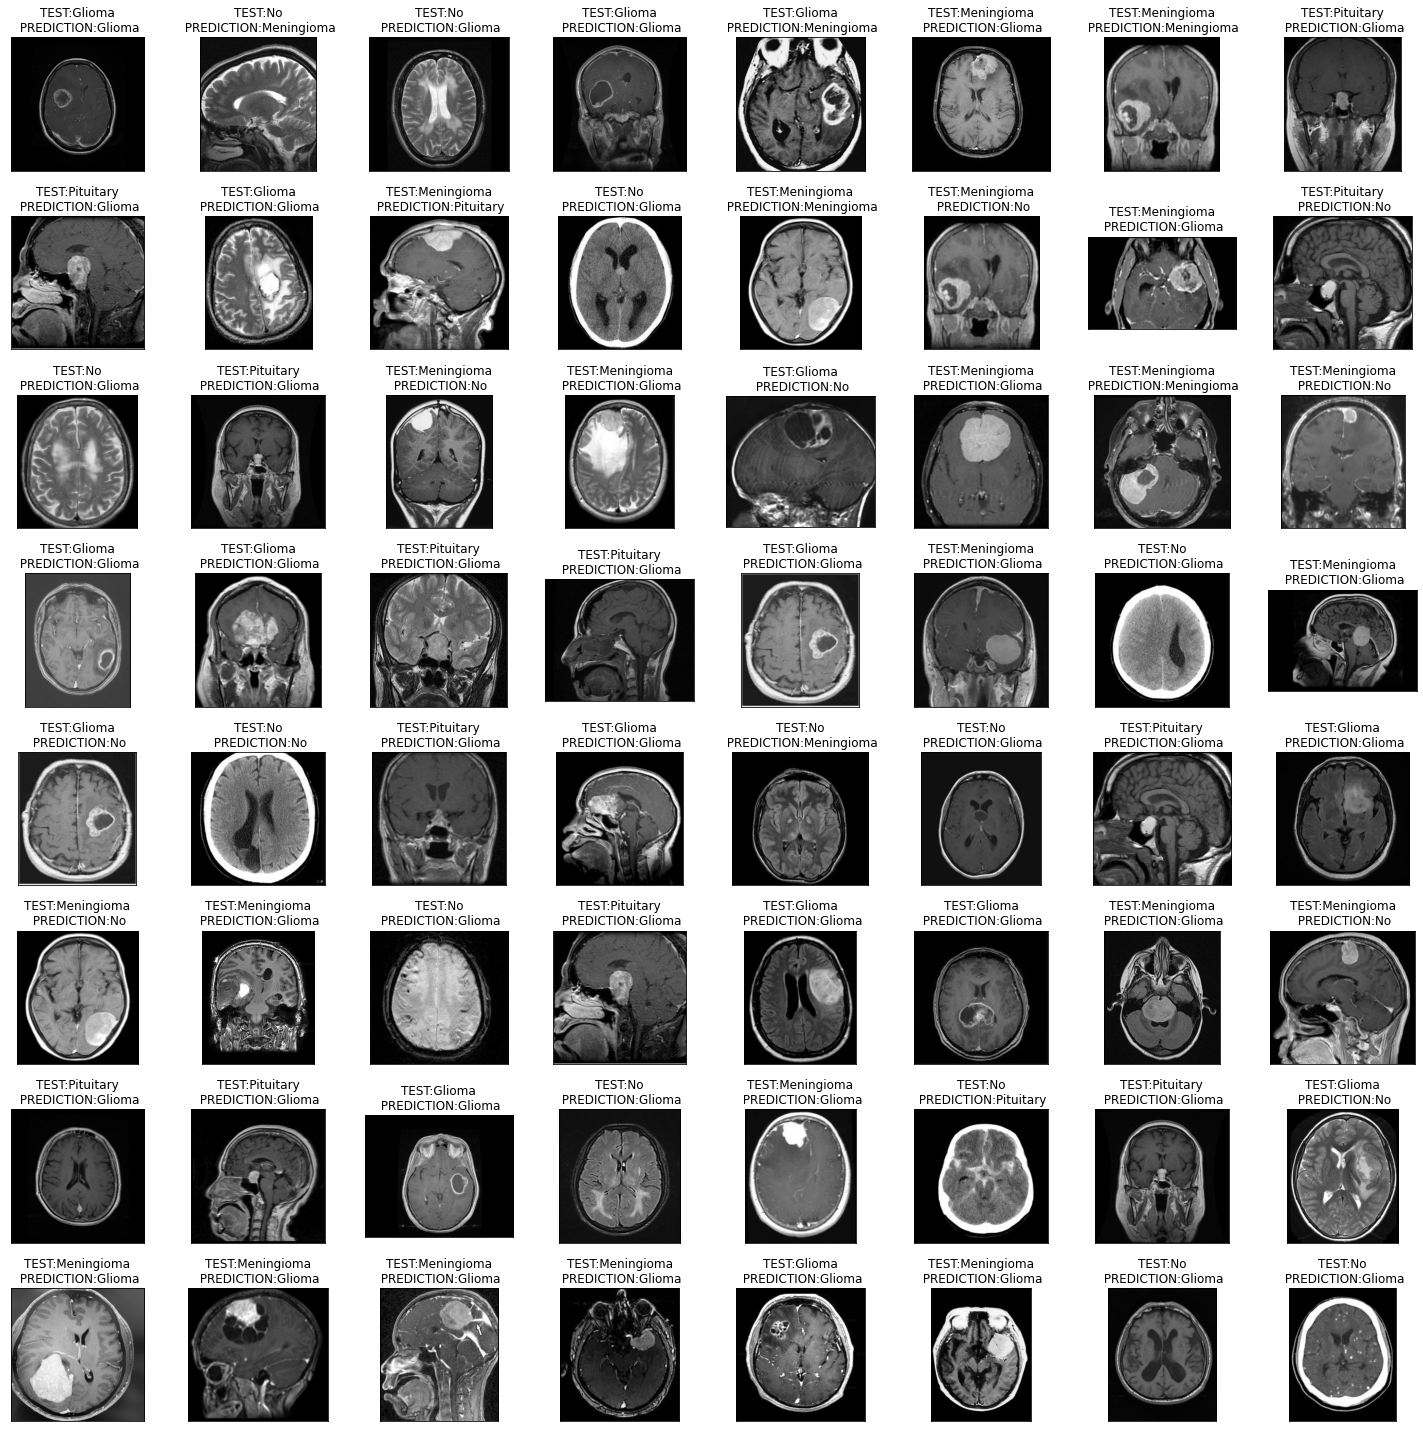

In [98]:
fig, axes = plt.subplots(nrows=8,
                         ncols=8,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Test_Data["JPG"].iloc[i]))
    ax.set_title(f"TEST:{Main_Test_Data.TUMOR_CATEGORY.iloc[i]}\n PREDICTION:{Combinaison_models[i]}")
plt.tight_layout()
plt.show()


# Applying a Pretrained model RESNET50
